# Import Prepared Data
On the previous noteboook "DiabetesEDA.ipynb" the data was prepared to a one-hot-encoder format for the categorical variables, several variables with an important number of missing values were droped and the numerical data was revised, the prepared data is available here.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [14]:
D_ROUTE = os.path.abspath(os.getcwd())
d_diab_dum = pd.read_pickle(f'{D_ROUTE}/Data/d_diab_dum.pickle')

## The Plan.
Now the steps for the analysis are:
1. Split the data into train, validate and test set with the distribution 80, 10, 10.
2. Train a base classification model.
3. Train Several Models, to se how they perform.
4. Make a grid search on the hyperparemeters of the best model to improve it.


#### Drop encounter_id and patient_nbr

In [15]:
ids_df = d_diab_dum[['encounter_id', 'patient_nbr']]
d_diab_dum = d_diab_dum.drop(['encounter_id', 'patient_nbr'], axis=1)
d_diab_dum

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted,...,glimepiride-pioglitazone_No,glimepiride-pioglitazone_Steady,metformin-rosiglitazone_No,metformin-rosiglitazone_Steady,metformin-pioglitazone_No,metformin-pioglitazone_Steady,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
0,0,1,41,0,1,0,0,0,1,1,...,1,0,1,0,1,0,0,1,1,0
1,10,3,59,0,18,0,0,0,9,0,...,1,0,1,0,1,0,1,0,0,1
2,20,2,11,5,13,2,0,1,6,1,...,1,0,1,0,1,0,0,1,0,1
3,30,2,44,1,16,0,0,0,7,1,...,1,0,1,0,1,0,1,0,0,1
4,40,1,51,0,8,0,0,0,5,1,...,1,0,1,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100109,70,3,51,0,16,0,0,0,9,0,...,1,0,1,0,1,0,1,0,0,1
100110,80,5,33,3,18,0,0,1,9,1,...,1,0,1,0,1,0,0,1,0,1
100111,70,1,53,0,9,1,0,0,13,1,...,1,0,1,0,1,0,1,0,0,1
100112,80,10,45,2,21,0,0,1,9,1,...,1,0,1,0,1,0,1,0,0,1


### 1. Split the data.

In [4]:
from sklearn.model_selection import train_test_split

In [16]:
y_cols = ['readmitted']
y = d_diab_dum[y_cols]
X = d_diab_dum.drop(y_cols, axis=1)


In [17]:
X_train, X_val, y_train, y_val = train_test_split(X,y,
                              test_size=0.1,
                              random_state=42,
                              )

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train,
                                                    test_size = (1/9),
                                                    random_state=42)

### Hideout.
`X_val` & `y_val` will be used has hideout set for validations.

## 2. Base Model

In [19]:
from xgboost import XGBClassifier
from xgboost import plot_importance

In [141]:
xgb_clf = XGBClassifier(n_estimators=500, 
                          n_jobs=10,
                          seed=42)

In [143]:
xgb_clf.fit(X_train,
        y_train,
        eval_metric = ['logloss','aucpr'],
        verbose=True)

/home/jvai/anaconda3/envs/dask/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=10, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=42, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [138]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [144]:
y_pred = xgb_clf.predict(X_test)

In [166]:
def get_metrics(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    psc = precision_score(y_test, y_pred, average='macro')
    resc = recall_score(y_test, y_pred, average='macro')
    
    print(f'Accuracy: {acc} \n \
Precision: {psc} \n \
Recall: {resc}')
    

get_metrics(xgb_clf, X_test, y_test)

Accuracy: 0.536 
 Precision: 0.3953433119505821 
 Recall: 0.393355901629427


In [146]:
multilabel_confusion_matrix(y_test, y_pred)

array([[[466, 199],
        [189, 146]],

       [[216, 226],
        [174, 384]],

       [[854,  39],
        [101,   6]]])

In [42]:
y_test.values.ravel()

array([2, 1, 1, ..., 1, 0, 1])

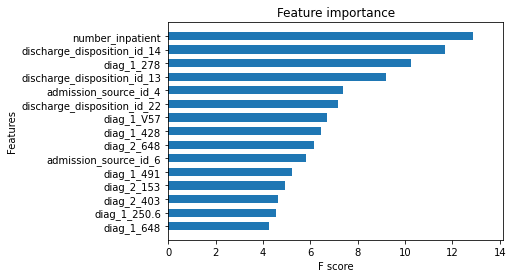

In [32]:
from xgboost import plot_importance
plot_importance(clf, importance_type='gain', max_num_features=15, 
                        show_values=False, height=0.6, grid=False)
plt.show()

### 3. Train Several Models.
For this exercise only 10% of the data will be used.

In [58]:
D_ROUTE = os.path.abspath(os.getcwd())
d_10_dum = pd.read_pickle(f'{D_ROUTE}/Data/d_diab_dum_10.pickle')

In [90]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier

In [125]:
def split_data(df, target_col, test_size):
    y = d_10_dum[target_col]
    y = y.values.ravel()
    X = d_10_dum.drop(target_col, axis=1)
    X = X.values


    X_train, X_test, y_train, y_test = train_test_split(X,y,
                                  test_size=0.1,
                                  random_state=42,
                                  )
    return X_train, X_test, y_train, y_test



# ids_df = d_10_dum[['encounter_id', 'patient_nbr']]
# d_10_dum = d_10_dum.drop(['encounter_id', 'patient_nbr'], axis=1)


X_train, X_test, y_train, y_test = split_data(d_10_dum,
                                              'readmitted',
                                              0.1)

In [110]:
rf = RandomForestClassifier(n_estimators = 500,
                            n_jobs = 10)
knn = KNN()

dt = DecisionTreeClassifier()

lr = LogisticRegression()

classifiers = [('Random Forest', rf),
               ('K Nearest Neighbours', knn),
               ('Decision Tree', dt)]

for clf_name, clf in classifiers:
		# fit clf to the training set
		clf.fit(X_train, y_train)
		
		# Predict the labels of the test set
		y_pred = clf.predict(X_test)
		
		# Evaluate the accuracy of clf on the test set
		print('{:s} : {:.3f}'.format(clf_name, accuracy_score(y_test, y_pred)))

Random Forest : 0.594
K Nearest Neighbours : 0.485
Decision Tree : 0.527


### Now some democracy:

In [94]:
vc = VotingClassifier(estimators=classifiers)

# Fit 'vc'to the training set and predict test set labels
vc.fit(X_train, y_train)
y_pred = vc.predict(X_test)

# Evaluate the test-set accuracy of 'vc'
print('Voting Classifier: {:.3f}'.format(accuracy_score(y_test, y_pred)))

Voting Classifier: 0.548


# Issues with the data?
The accuracy of any of the models tested before is still to low, for make improvements in any of them. Even training with all the data on a XGBClassifier wasn't enough to have significant results. but what about the features that might be causing noise?

# PCA
Is possible that a dimentionality reduction makes the training data more insightful for posterior analysis. PCA only works for ordinal features so it will be applied to this columns only.

In [113]:
ord_d_dum = d_diab_dum[['age',
            'time_in_hospital',
            'num_lab_procedures',
            'num_procedures',
            'num_medications',
            'number_diagnoses',
            'readmitted']]

In [114]:
ord_d_dum.shape

(100114, 7)

In [127]:

X_train, X_test, y_train, y_test = split_data(ord_d_dum,
                                              'readmitted',
                                              0.1)

In [118]:
# Testing a Random Forest first with only ordinal variables.
rf = RandomForestClassifier(n_estimators = 500,
                            n_jobs = 10)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test, y_pred)


0.48651618058330004

In [119]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca_train = pca.fit_transform(X_train)
pca_test = pca.fit_transform(X_test)

In [120]:
rf.fit(pca_train, y_train)
y_pred = rf.predict(pca_test)
accuracy_score(y_test, y_pred)

0.51078705553336

### Only a slight Improvement
It seems like decorrelating the data didn't had a mayor effect on the performance, but on the contrary aumented the bias of the model, can the inbalance of the categorical variables related to diagnosis hava an impact on the performance?. To test this a subset data set named d_diab_no_diag was created on the EDA Notebook.

In [130]:
d_diab_no_diag = pd.read_pickle(f'{D_ROUTE}/Data/d_diab_no_diag_10.pickle')

In [131]:
ids_df = d_diab_no_diag[['encounter_id', 'patient_nbr']]
d_diab_no_diag = d_diab_no_diag.drop(['encounter_id', 'patient_nbr'], axis=1)



In [171]:
X_train, X_test, y_train, y_test = split_data(d_diab_no_diag,
                                              'readmitted',
                                              0.1)

rf = RandomForestClassifier(n_estimators = 500,
                            n_jobs = 10)
rf.fit(X_train, y_train)



RandomForestClassifier(n_estimators=500, n_jobs=10)

In [170]:
get_metrics(rf, X_test, y_test)

Accuracy: 0.593 
 Precision: 0.36980659672158556 
 Recall: 0.39798320226822875


/home/jvai/anaconda3/envs/dask/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Conclusion.

None of the methods explored before was able to classify the samples with enough accuracy, further exploration of the data is needed and also the possibility of converting the problem to a binary classification problem by having only Radmittions and No Readmitions
